# Implementar o CausalGAN

2- Então usar as ideias do CausalGAN: [CausalGAN: Learning Causal Implicit Generative Models with Adversarial Training](https://arxiv.org/abs/1709.02023)

## Construir o Dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
n_samples = 30000
genero = np.random.choice([0,1],size=n_samples,p=[0.53,0.47]).reshape(n_samples,1)
idade = np.random.choice([0,1],size=n_samples,p=[0.65,0.35]).reshape(n_samples,1)
regiao = np.random.choice([0,1,2,3],size=n_samples,p=[0.2,0.3,0.4,0.1]).reshape(n_samples,1)

In [3]:
def gen_bigode(genero,idade):
    prob_bigode_velho = [0.4,0.6]
    prob_bigode_novo = [0.55,0.45]
    bigode = np.zeros(shape=(genero.shape[0],1))
    for i in range(genero.shape[0]):
        if genero[i] == 1 and idade[i]==1:
            bigode[i] = np.random.choice([0,1],p=prob_bigode_velho)
        elif genero[i] == 1 and idade[i]==0:
            bigode[i] = np.random.choice([0,1],p=prob_bigode_novo)
    return bigode

def gen_careca(genero,idade):
    prob_careca_velho = [0.3,0.7]
    prob_careca_novo = [0.8,0.2]
    careca = np.zeros(shape=(genero.shape[0],1))
    for i in range(genero.shape[0]):
        if genero[i] == 1 and idade[i]==1:
            careca[i] = np.random.choice([0,1],p=prob_careca_velho)
        if genero[i] == 1 and idade[i]==0:
            careca[i] = np.random.choice([0,1],p=prob_careca_novo)
    return careca

def gen_cabelo(regiao,careca):
    prob_cabelo_america = [0.45,0.40,0.15]
    prob_cabelo_europa = [0.35,0.40,0.25]
    prob_cabelo_asia = [0.9,0.09,0.01]
    prob_cabelo_oceania = [0.4,0.5,0.1]
    cabelo = np.zeros(shape=(regiao.shape[0],1))
    for i in range(regiao.shape[0]):
        if careca[i] == 0 and regiao[i]==0:
            cabelo[i] = np.random.choice([0,1,2],p=prob_cabelo_america)
        elif careca[i] == 0 and regiao[i]==1:
            cabelo[i] = np.random.choice([0,1,2],p=prob_cabelo_europa)
        elif careca[i] == 0 and regiao[i]==2:
            cabelo[i] = np.random.choice([0,1,2],p=prob_cabelo_asia)
        elif careca[i] == 0 and regiao[i]==3:
            cabelo[i] = np.random.choice([0,1,2],p=prob_cabelo_oceania)
        elif careca[i] == 1:
            cabelo[i] = 3
    return cabelo

def gen_oculos(idade):
    prob_oculos_velho = [0.4,0.6]
    prob_oculos_novo = [0.8,0.2]
    oculos = np.zeros(shape=(idade.shape[0],1))
    for i in range(idade.shape[0]):
        if idade[i] == 1:
            oculos[i] = np.random.choice([0,1],p=prob_oculos_velho)
        elif idade[i] == 0:
            oculos[i] = np.random.choice([0,1],p=prob_oculos_novo)
    return oculos

In [4]:
bigode = gen_bigode(genero,idade)
oculos = gen_oculos(idade)
careca = gen_careca(genero,idade)
cabelo = gen_cabelo(regiao,careca)

In [5]:
X_features = np.concatenate((genero,idade,cabelo,regiao,oculos,bigode,careca),axis=1)

In [6]:
df_num_ = pd.DataFrame(data=X_features,columns=['genero','idade','cabelo','regiao','oculos','bigode','careca']).astype(int)
df_num = df_num_[['genero','idade','oculos','bigode','careca']].copy()

In [7]:
df_num = pd.concat([df_num,pd.get_dummies(df_num_['regiao'],prefix='regiao',prefix_sep='_')],axis=1)
df_num = pd.concat([df_num,pd.get_dummies(df_num_['cabelo'],prefix='cabelo',prefix_sep='_')],axis=1)

In [8]:
df_num.head(2)

,genero,idade,oculos,bigode,careca,regiao_0,regiao_1,regiao_2,regiao_3,cabelo_0,cabelo_1,cabelo_2,cabelo_3
0,0,1,1,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,1,0


In [9]:
tradutor = {"genero":{0:"mulher",1:"homem"},
           "idade":{0:"novo",1:"velho"},
            "cabelo":{0:"escuro",1:"claro",2:"vermelho",3:"ausente"},
            "regiao":{0:"america",1:"europa",2:"asia",3:"oceania"},
            "oculos":{0:"sem oculos",1:"com oculos"},
            "bigode":{0:"sem bigode",1:"com bigode"},
            "careca":{0:"nao",1:"sim"}
           }

In [10]:
df_text = df_num_.copy()

In [11]:
for col in df_num_.columns:
    df_text[col] = df_num_[col].map(tradutor[col])

In [12]:
df_text.head()

,genero,idade,cabelo,regiao,oculos,bigode,careca
0,mulher,velho,escuro,america,com oculos,sem bigode,nao
1,mulher,novo,vermelho,america,sem oculos,sem bigode,nao
2,mulher,velho,escuro,europa,sem oculos,sem bigode,nao
3,homem,velho,ausente,europa,com oculos,sem bigode,sim
4,homem,velho,vermelho,oceania,com oculos,com bigode,nao


In [15]:
# df_text.to_csv("data/counter_factual_data_example_text.csv",index=False)

In [13]:
print(f"Mulheres com bigode: {df_num[(df_num['genero']==0)&(df_num['bigode']==1)].shape[0]}")
print(f"Mulheres carecas: {df_num[(df_num['genero']==0)&(df_num['careca']==1)].shape[0]}")
print(f"Carecas com cabelo: {df_num[(df_num['careca']==1)&(df_num['cabelo_3']!=1)].shape[0]}")

Mulheres com bigode: 0
Mulheres carecas: 0
Carecas com cabelo: 0


---
### Funções de auxílio

In [97]:
def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Anti-Labeler')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Labeler')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()

## CausalGAN

- Causal Controller: usaremos apenas um label, `bigode`. Portanto o `Causal Controller` vai enviar uma variável aleatória binária, `Lg` indicando esta label que, portanto, será retirada do `dataset`.
- Anti-Labeler: receberá o `G(Z,Lg)` e estimará a label do dado gerado.
- Labeler: receberá o `G(Z,Lg)` e `X` e estimará a label real, `X`.
- Gerador: receberá o ruído `Z` e a label `Lg` e retornará o dado `G(Z,Lg)`.
- Discriminador: receberá `G(Z,Lg)` e `X` e retornará a probabilidade do dado ser real.

In [98]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
# probabilidade de ocorre bigode=1 no dataset
rho = df_num[df_num["bigode"]==1].shape[0]/df_num.shape[0]
rho

0.24

In [100]:
X_data = df_num.copy().values
y_data = df_num["bigode"].copy().values.reshape(X_data.shape[0],1)
X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
y_tc = torch.Tensor(y_data).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([30000, 13]) torch.FloatTensor torch.Size([30000, 1]) torch.FloatTensor


In [101]:
# dataset com apenas um valor da label
X_label_0 = torch.Tensor(df_num[df_num['bigode']==0].values).type(torch.FloatTensor)
X_label_1 = torch.Tensor(df_num[df_num['bigode']==1].values).type(torch.FloatTensor)

In [103]:
batch_size = 200
torch_dataset = Data.TensorDataset(X_tc,y_tc)
loader = Data.DataLoader(
        dataset = torch_dataset,
        batch_size = batch_size,
        pin_memory=True,
        shuffle=True)
torch_dataset_label1 = Data.TensorDataset(X_label_1)
loader_label1 = Data.DataLoader(
        dataset = torch_dataset_label1,
        batch_size = batch_size,
        pin_memory=True,
        shuffle=True)
torch_dataset_label0 = Data.TensorDataset(X_label_0)
loader_label0 = Data.DataLoader(
        dataset = torch_dataset_label0,
        batch_size = batch_size,
        pin_memory=True,
        shuffle=True)

In [104]:
Z_dim,h_dim,X_dim,y_dim = [10,50,X_tc.shape[1],y_tc.shape[1]]

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden = torch.nn.Linear(Z_dim+1, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,lg):
        h = F.relu(self.hidden(torch.cat((z,lg),dim=1)))
        X = torch.sigmoid(self.out(h))
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X):
        h = F.relu(self.hidden(X))
        y = torch.sigmoid(self.out(h))
        return y

# Arquitetura do Anti_labeler
class Antilabeler(torch.nn.Module):
    def __init__(self):
        super(Antilabeler,self).__init__()
        self.hidden = torch.nn.Linear(X_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,G_sample):
        h = F.relu(self.hidden(G_sample))
        lg_estimate = torch.sigmoid(self.out(h))
        return lg_estimate

# Arquitetura do Labeler
class Labeler(torch.nn.Module):
    def __init__(self):
        super(Labeler,self).__init__()
        self.hidden = torch.nn.Linear(X_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X):
        h = F.relu(self.hidden(X))
        lr_estimate = torch.sigmoid(self.out(h))
        return lr_estimate

In [105]:
# Instanciamos as redes
G = GNet().cuda()
D = DNet().cuda()
A = Antilabeler().cuda()
L = Labeler().cuda()

# Definimos os otimizadores
lrg,lrd,lra,lrl = [1e-5,1e-5,1e-3,1e-3]
G_optim = optim.Adam(G.parameters(), lr=lrg)
D_optim = optim.Adam(D.parameters(), lr=lrd)
A_optim = optim.Adam(A.parameters(), lr=lra)
L_optim = optim.Adam(L.parameters(), lr=lrl)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight).cuda()
        m.bias.data.fill_(0.0001)  

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()
    A_optim.zero_grad()
    L_optim.zero_grad()

ones  = Variable(torch.ones(batch_size, 1)).cuda()
zeros = Variable(torch.zeros(batch_size, 1)).cuda()
ONES  = Variable(torch.ones(X_dim, 1)).cuda()
ZEROS = Variable(torch.zeros(X_dim, 1)).cuda()

def nets_test(n_sample,G,D,A,L,rho):
    g = G(Variable(torch.randn(n_sample, Z_dim)).cuda(),torch.Tensor([np.random.choice([0,1],p=[1-rho,rho])]*n_sample).reshape(-1,1).cuda())
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    D_real = D(x)
    D_fake = D(g)
    A_g = A(g)
    L_r = L(x)
    print('Average D_real  {:.6f}| Std D_real  {:.6f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.6f}| Std D_fake  {:.6f}'.format(D_fake.mean(),D_fake.std()))
    print('Average Anti-L  {:.6f}| Std Anti-L  {:.6f}'.format(A_g.mean(),A_g.std()))
    print('Average Labeler {:.6f}| Std Labeler {:.6f}'.format(L_r.mean(),L_r.std()))

In [113]:
%%time
epochs = 50000
epochs_extra = 5
G_his, D_his,A_his,L_his = [[],[],[],[]]
losses_his = [G_his,D_his,A_his,L_his]

G.apply(init_weights)
D.apply(init_weights)
A.apply(init_weights)
L.apply(init_weights)

for epoch in range(epochs):
    for i in range(epochs_extra):
        batch_data = next(iter(loader))
        # Generator
        X  = Variable(batch_data[0]).cuda()
        Lr = Variable(batch_data[1]).cuda()
        Lg = Variable(torch.Tensor([np.random.choice([0,1],p=[1-rho,rho])]*batch_size)).reshape(-1,1).cuda()
        z  = Variable(torch.randn(batch_size, Z_dim)).cuda()
        Z  = Variable(torch.randn(X_dim, Z_dim)).cuda()
        G_sample    = G(z,Lr)
        D_real      = D(X)
        D_fake      = D(G_sample)
        L_l1        = L(G(Z,ONES))
        L_l0        = L(G(Z,ZEROS))
        A_l1        = A(G(Z,ONES))
        A_l0        = A(G(Z,ZEROS))
        G_loss      = (torch.mean(torch.log((1-D_fake)/(D_fake))) \
                  - (rho*torch.mean(torch.log(L_l1)) + (1-rho)*torch.mean(torch.log(1-L_l0))) \
                  + (rho*torch.mean(torch.log(A_l1)) + (1-rho)*torch.mean(torch.log(1-A_l0))))
        G_loss.backward()
        G_optim.step()
        reset_grad()
        
    batch_data = next(iter(loader))
    X_l1 = Variable(next(iter(torch_dataset_label1))[0]).cuda()
    X_l0 = Variable(next(iter(torch_dataset_label0))[0]).cuda()
    X    = Variable(batch_data[0]).cuda()
    Lr   = Variable(batch_data[1]).cuda()
    Lg   = Variable(torch.Tensor([np.random.choice([0,1],p=[1-rho,rho])]*batch_size)).reshape(-1,1).cuda()
    z    = Variable(torch.randn(batch_size, Z_dim)).cuda()   
    
    # Discriminador
    G_sample = G(z,Lr)
    D_real   = D(X)
    D_fake   = D(G_sample)
    D_loss   = -(torch.mean(torch.log(D_real)) + torch.mean(torch.log((1-D_fake))))
    D_loss.backward(retain_graph=True)
    D_optim.step()

    # Antilabeler
    A_l1   = A(G(z,ones))
    A_l0   = A(G(z,zeros))
    A_loss = -(rho*torch.mean(torch.log(A_l1)) + (1-rho)*torch.mean(torch.log(1-A_l0)))
    A_loss.backward()
    A_optim.step()

    # Labeler
    L_l1   = L(X_l1)
    L_l0   = L(X_l0)    
    L_loss = -(rho*torch.mean(torch.log(L_l1)) + (1-rho)*torch.mean(torch.log(1-L_l0)))
    L_loss.backward()
    L_optim.step()
    reset_grad()
    
    # losses
    G_his.append(G_loss.mean().data)
    D_his.append(D_loss.mean().data)
    A_his.append(A_loss.mean().data)
    L_his.append(L_loss.mean().data)

    if epoch % int(epochs/5) == 0:
        print('Epoch-{}'.format(epoch))
        nets_test(5000,G,D,A,L,rho)

Epoch-0
Average D_real  0.389837| Std D_real  0.068023
Average D_fake  0.366328| Std D_fake  0.013426
Average Anti-L  0.640820| Std Anti-L  0.010083
Average Labeler 0.507950| Std Labeler 0.032182
Epoch-10000
Average D_real  0.585033| Std D_real  0.059638
Average D_fake  0.513461| Std D_fake  0.018979
Average Anti-L  0.430858| Std Anti-L  0.239661
Average Labeler 0.426761| Std Labeler 0.442806
Epoch-20000
Average D_real  0.578399| Std D_real  0.077438
Average D_fake  0.426694| Std D_fake  0.038311
Average Anti-L  0.162513| Std Anti-L  0.181224
Average Labeler 0.412536| Std Labeler 0.453491
Epoch-30000
Average D_real  0.635583| Std D_real  0.109092
Average D_fake  0.365980| Std D_fake  0.048957
Average Anti-L  0.091777| Std Anti-L  0.163938
Average Labeler 0.373116| Std Labeler 0.442937
Epoch-40000
Average D_real  0.582310| Std D_real  0.131298
Average D_fake  0.406064| Std D_fake  0.042958
Average Anti-L  0.025534| Std Anti-L  0.099495
Average Labeler 0.356141| Std Labeler 0.439736
CPU 

In [114]:
print('p = P(l=1)')
nets_test(5000,G,D,A,L,rho)
print('p = P(x|l=0)')
nets_test(5000,G,D,A,L,0.)
print('p = P(x|l=1)')
nets_test(5000,G,D,A,L,1.)

p = P(l=1)
Average D_real  0.550441| Std D_real  0.099175
Average D_fake  0.555629| Std D_fake  0.057730
Average Anti-L  0.999408| Std Anti-L  0.016970
Average Labeler 0.353185| Std Labeler 0.439528
p = P(x|l=0)
Average D_real  0.550441| Std D_real  0.099175
Average D_fake  0.436471| Std D_fake  0.081397
Average Anti-L  0.000237| Std Anti-L  0.008815
Average Labeler 0.353185| Std Labeler 0.439528
p = P(x|l=1)
Average D_real  0.550441| Std D_real  0.099175
Average D_fake  0.555913| Std D_fake  0.058407
Average Anti-L  0.999247| Std Anti-L  0.020704
Average Labeler 0.353185| Std Labeler 0.439528


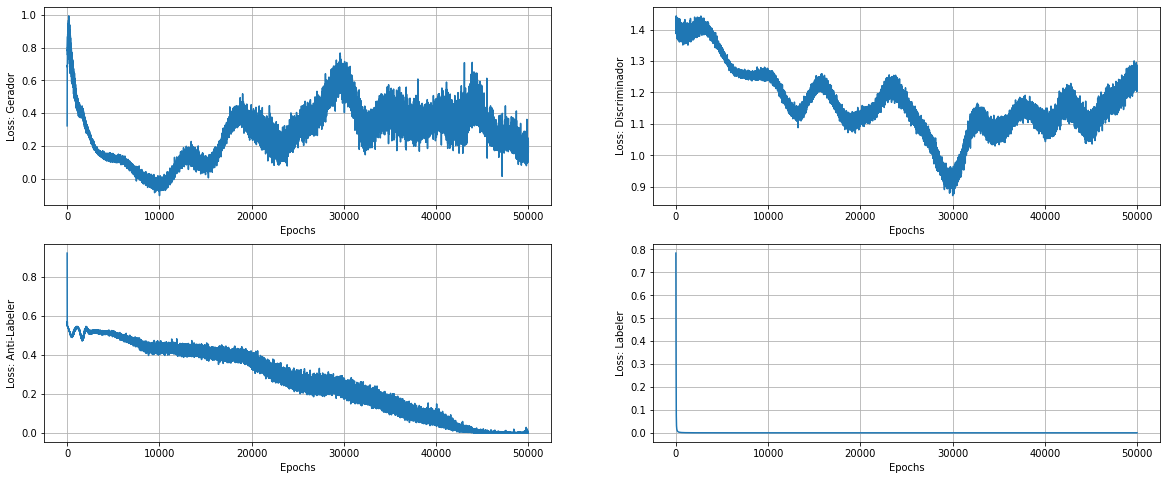

In [115]:
plot_losses(losses_his)

In [143]:
g = G(Variable(torch.randn(30000, Z_dim)).cuda(),torch.Tensor([np.random.choice([0,1],p=[1-rho,rho])]*30000).reshape(-1,1).cuda())
# g = G(Variable(torch.randn(30000, Z_dim)).cuda(),torch.Tensor([1]*30000).reshape(-1,1).cuda())

In [144]:
df_g = pd.DataFrame(data=np.round(g.cpu().data.numpy(),0),columns=df_num.columns).astype(int)

In [145]:
#dataset fake
print('mulheres de bigode: {}| homens de bigode: {}'\
      .format(df_g[(df_g['genero']==0)&(df_g['bigode']==1)].shape[0],
             df_g[(df_g['genero']==1)&(df_g['bigode']==1)].shape[0]))
print('novos de oculos: {}| velhos de oculos: {}'\
      .format(df_g[(df_g['idade']==0)&(df_g['oculos']==1)].shape[0],
             df_g[(df_g['idade']==1)&(df_g['oculos']==1)].shape[0]))

mulheres de bigode: 903| homens de bigode: 13024
novos de oculos: 20577| velhos de oculos: 8912


In [146]:
#dataset real
print('mulheres de bigode: {}| homens de bigode: {}'\
      .format(df_num[(df_num['genero']==0)&(df_num['bigode']==1)].shape[0],
             df_num[(df_num['genero']==1)&(df_num['bigode']==1)].shape[0]))
print('novos de oculos: {}| velhos de oculos: {}'\
      .format(df_num[(df_num['idade']==0)&(df_num['oculos']==1)].shape[0],
             df_num[(df_num['idade']==1)&(df_num['oculos']==1)].shape[0]))

mulheres de bigode: 0| homens de bigode: 7200
novos de oculos: 3926| velhos de oculos: 6368


In [147]:
#dataset fake
print('mulheres carecas: {}| homens carecas: {}'\
      .format(df_g[(df_g['genero']==0)&(df_g['careca']==1)].shape[0],
             df_g[(df_g['genero']==1)&(df_g['careca']==1)].shape[0]))
print('novos carecas: {}| velhos carecas: {}'\
      .format(df_g[(df_g['idade']==0)&(df_g['careca']==1)].shape[0],
             df_g[(df_g['idade']==1)&(df_g['careca']==1)].shape[0]))

mulheres carecas: 0| homens carecas: 3872
novos carecas: 2894| velhos carecas: 978


In [148]:
#dataset real
print('mulheres carecas: {}| homens carecas: {}'\
      .format(df_num[(df_num['genero']==0)&(df_num['careca']==1)].shape[0],
             df_num[(df_num['genero']==1)&(df_num['careca']==1)].shape[0]))
print('novos carecas: {}| velhos carecas: {}'\
      .format(df_num[(df_num['idade']==0)&(df_num['careca']==1)].shape[0],
             df_num[(df_num['idade']==1)&(df_num['careca']==1)].shape[0]))

mulheres carecas: 0| homens carecas: 5258
novos carecas: 1793| velhos carecas: 3465


In [149]:
#dataset fake
print('proporcao de novos sem oculos: {:.4f}'\
      .format(df_g[(df_g['idade']==0)&(df_g['oculos']==0)].shape[0]/\
             df_g[df_g['idade']==0].shape[0]))
print('proporcao de velhos sem oculos: {:.4f}'\
      .format(df_g[(df_g['idade']==1)&(df_g['oculos']==0)].shape[0]/\
             df_g[df_g['idade']==1].shape[0]+0.001))

proporcao de novos sem oculos: 0.0240
proporcao de velhos sem oculos: 0.0016


In [150]:
#dataset real
print('proporcao de novos sem oculos: {:.4f}'\
      .format(df_num[(df_num['idade']==0)&(df_num['oculos']==0)].shape[0]/\
             df_num[df_num['idade']==0].shape[0]))
print('proporcao de velhos sem oculos: {:.4f}'\
      .format(df_num[(df_num['idade']==1)&(df_num['oculos']==0)].shape[0]/\
             df_num[df_num['idade']==1].shape[0]))

proporcao de novos sem oculos: 0.7982
proporcao de velhos sem oculos: 0.3962


In [151]:
for col in df_num.columns:
    print('variacao de {} em relacao ao real: {:.2%}'\
          .format(col,
                  (df_num[col].value_counts().values[0]-df_g[col].value_counts().values[0])/df_num[col].value_counts().values[0]))

variacao de genero em relacao ao real: -12.37%
variacao de idade em relacao ao real: -8.37%
variacao de oculos em relacao ao real: -49.64%
variacao de bigode em relacao ao real: 29.50%
variacao de careca em relacao ao real: -5.60%
variacao de regiao_0 em relacao ao real: -21.08%
variacao de regiao_1 em relacao ao real: -35.62%
variacao de regiao_2 em relacao ao real: -65.66%
variacao de regiao_3 em relacao ao real: -10.13%
variacao de cabelo_0 em relacao ao real: -88.35%
variacao de cabelo_1 em relacao ao real: 15.99%
variacao de cabelo_2 em relacao ao real: -0.14%
variacao de cabelo_3 em relacao ao real: 19.69%
